The Spectrum-Based SNR Estimator is a non-data-aided method that estimates signal-to-noise ratio by analyzing the spectral characteristics of the received signal, typically using frequency domain tools like the FFT. 

. Maximum likelihood SNR estimation combined with energy detection has been tested on GNU Radio with USRP platforms demonstrating practical viability.
https://arxiv.org/pdf/1708.06802

. Subspace methods and spectrum-based estimators are often complementary, with spectrum-based methods providing more straightforward implementation
http://scielo.sld.cu/scielo.php?script=sci_arttext&pid=S1815-59282019000200049

In [29]:
import torch

def ml_snr_estimation(noisy_audio: torch.Tensor, noise_audio: torch.Tensor) -> torch.Tensor:
    """
    ML-based SNR estimation for bandabase signals using PyTorch tensors.

    Args:
        noisy_audio (torch.Tensor): Tensor of noisy audio samples, shape (N,)
        noise_audio (torch.Tensor): Tensor of noise-only audio samples, shape (M,)

    Returns:
        torch.Tensor: Estimated SNR in dB (scalar tensor)
    """
    # Estimate noise power from noise-only segment
    noise_power = torch.mean(noise_audio ** 2)
    
    # Estimate total power from noisy audio segment
    total_power = torch.mean(noisy_audio ** 2)
    
    # Estimate signal power assuming noise and signal are uncorrelated
    signal_power = total_power - noise_power
    
    if signal_power <= 0:
        raise ValueError("Estimated signal power is not positive; check input tensors.")
    
    # Calculate SNR (linear) and convert to dB
    snr_linear = signal_power / noise_power
    snr_db = 10 * torch.log10(snr_linear)
    
    return snr_db


# Example use with CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate synthetic data for demo (replace with real audio tensors)
fs = 16000
duration = 2  # seconds
t = torch.linspace(0, duration, int(fs * duration), device=device)

# Tone frequency (clean signal)
freq = 440  # A4 note
clean_signal = 1 * torch.sin(2 * torch.pi * freq * t).to(device)

# Noise segment (noise-only)
noise_only = 0.3 * torch.randn_like(clean_signal)

# Noisy audio
noisy_audio = clean_signal + noise_only

# Estimate SNR
estimated_snr_db = ml_snr_estimation(noisy_audio, noise_only)
print(f"Estimated SNR (dB): {estimated_snr_db.item():.2f}")

Estimated SNR (dB): 7.43



Random integer-valued frequency for last run: (7, 61, 723, 2722) Hz
Number of unique frequency sets: 120

SNR Statistics over 120 runs:
Average SNR: 8.24 dB
Standard deviation: 0.10 dB
Standard error: 0.009 dB
Average SNR_var: 0.01 dB
Standard deviation: 0.00 dB
Standard error: 0.009 dB

95% Confidence Interval for Mean SNR:
  [8.22, 8.26] dB
  Width: 0.04 dB

95% Prediction Interval for Individual Measurements:
  [8.04, 8.44] dB

Bootstrap 95% Confidence Interval for Mean:
  [8.22, 8.26] dB
  Width: 0.04 dB

Average theoretical SNR variance: 0.0053 dB²
Theoretical standard deviation: 0.073 dB


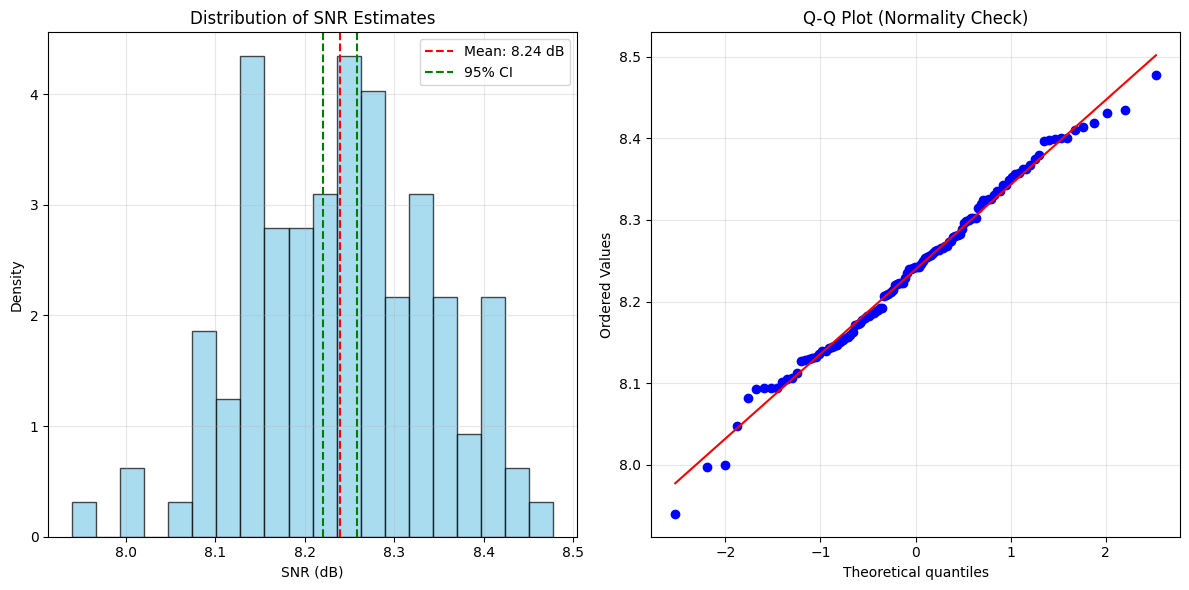

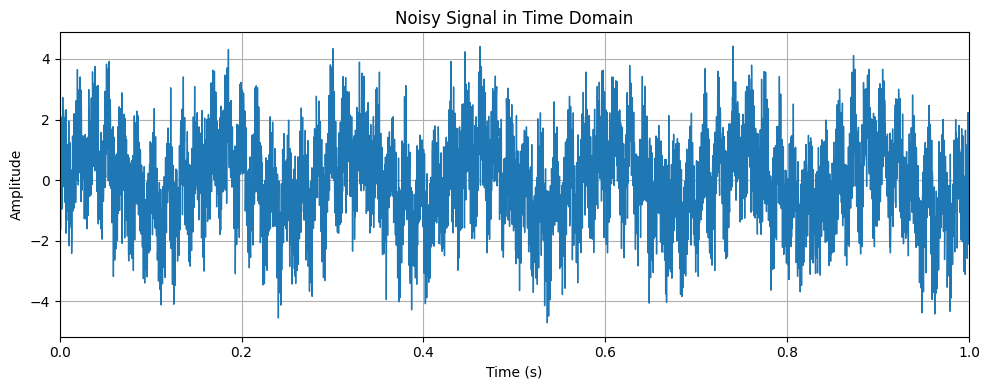

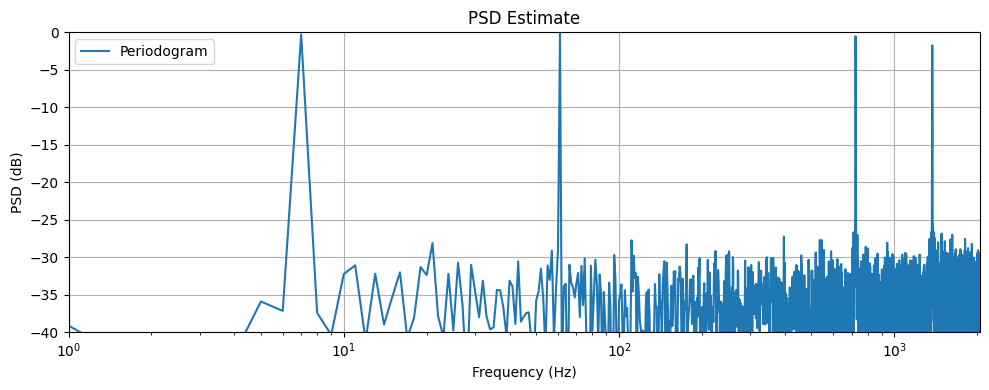

In [30]:
import torch
import torch.fft
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

class SignalGen:
    def __init__(self, fs=8192, T=1.0, amplitudes=(1, 1, 1, 1), noise_variance=0.09, seed=42):
        self.fs = fs
        self.T = T
        self.amplitudes = amplitudes
        self.noise_variance = noise_variance
        self.seed = seed

    def generate(self):
        # Reset RNG state explicitly
        torch.manual_seed(self.seed)
        
        # Generate random frequencies
        frequencies = [
            torch.randint(low=3, high=9, size=(1,)).item(),        # 3-8 Hz
            torch.randint(low=10, high=99, size=(1,)).item(),      # 10-98 Hz
            torch.randint(low=100, high=999, size=(1,)).item(),    # 100-998 Hz
            torch.randint(low=1000, high=3400, size=(1,)).item()   # 1000-3399 Hz
        ]
        
        n_samples = int(self.fs * self.T)
        t = torch.linspace(0, self.T, n_samples, dtype=torch.float32)
        
        # Generate clean signal
        x_clean = sum(a * torch.sin(2 * torch.pi * f * t) for a, f in zip(self.amplitudes, frequencies))
        
        # Generate noise - ensure different noise for each call
        noise = torch.sqrt(torch.tensor(self.noise_variance)) * torch.randn(n_samples)
        
        x_noisy = x_clean + noise
        return t, x_noisy, x_clean, frequencies

class PSDAnalyzer:
    def __init__(self, fs=8192):
        self.fs = fs

    def estimate_psd_periodogram(self, x):
        N = len(x)
        Xf = torch.fft.fft(x)
        psd = torch.abs(Xf)**2 / (self.fs * N)
        freqs = torch.fft.fftfreq(N, d=1.0/self.fs)
        
        # Select only positive frequencies
        positive = freqs >= 0
        freqs_pos = freqs[positive]
        psd_pos = psd[positive]
        
        # Double power for positive frequencies (except DC and Nyquist if present)
        psd_pos = 2 * psd_pos
        psd_pos[0] /= 2  # DC component should not be doubled
        
        # Handle Nyquist frequency for even N
        if N % 2 == 0:
            psd_pos[-1] /= 2  # Nyquist frequency should not be doubled
        
        return freqs_pos, psd_pos

    def estimate_snr_CleanS(self, x_clean, x_noisy):
        """
        Estimates SNR by comparing clean and noisy signals.
        
        Args:
            x_clean (torch.Tensor): Clean signal without noise
            x_noisy (torch.Tensor): Noisy signal
            
        Returns:
            float: SNR in dB
        """
        noise = x_noisy - x_clean
        power_signal = torch.mean(x_clean ** 2)
        power_noise = torch.mean(noise ** 2)
        
        # Add small epsilon to avoid division by zero
        epsilon = 1e-10
        snr_linear = power_signal / (power_noise + epsilon)
        snr_db = 10 * torch.log10(snr_linear)
        return snr_db.item()

    def estimate_snr_with_variance(self, x_clean, x_noisy, N_samples):
        """
        Estimates SNR with theoretical variance for confidence intervals.
        
        Args:
            x_clean (torch.Tensor): Clean signal without noise
            x_noisy (torch.Tensor): Noisy signal
            N_samples (int): Number of samples in the signal
            
        Returns:
            tuple: (SNR in dB, variance of SNR estimate in dB^2)
        """
        noise = x_noisy - x_clean
        power_signal = torch.mean(x_clean ** 2)
        power_noise = torch.mean(noise ** 2)
        
        # SNR in linear scale
        snr_linear = power_signal / power_noise
        snr_db = 10 * torch.log10(snr_linear)
        
        # Theoretical variance of SNR estimate in dB
        # For large N, the variance of SNR estimate in dB is approximately:
        # Var(SNR_dB) ≈ (10/ln(10))^2 * (1/N) * (1 + 1/SNR_linear)
        conversion_factor = (10 / np.log(10))**2  # ≈ 188.5
        snr_variance_db = conversion_factor * (1 / N_samples) * (1 + 1 / snr_linear)
        
        return snr_db.item(), snr_variance_db.item()

    def compute_confidence_intervals(self, snr_values, confidence_level=0.95):
        """
        Computes confidence intervals for SNR estimates.
        
        Args:
            snr_values (list): List of SNR values in dB
            confidence_level (float): Confidence level (e.g., 0.95 for 95%)
            
        Returns:
            dict: Dictionary containing confidence interval statistics
        """
        snr_array = np.array(snr_values)
        n = len(snr_array)
        
        # Sample statistics
        mean_snr = np.mean(snr_array)
        std_snr = np.std(snr_array, ddof=1)  # Sample standard deviation
        se_snr = std_snr / np.sqrt(n)  # Standard error of the mean
        
        # t-distribution critical value
        alpha = 1 - confidence_level
        t_critical = stats.t.ppf(1 - alpha/2, df=n-1)
        
        # Confidence interval for the mean
        ci_lower = mean_snr - t_critical * se_snr
        ci_upper = mean_snr + t_critical * se_snr
        
        # Prediction interval for individual measurements
        pred_lower = mean_snr - t_critical * std_snr * np.sqrt(1 + 1/n)
        pred_upper = mean_snr + t_critical * std_snr * np.sqrt(1 + 1/n)
        
        return {
            'mean': mean_snr,
            'std': std_snr,
            'se': se_snr,
            'n': n,
            'confidence_level': confidence_level,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'ci_width': ci_upper - ci_lower,
            'pred_lower': pred_lower,
            'pred_upper': pred_upper,
            't_critical': t_critical
        }

    def bootstrap_confidence_interval(self, snr_values, confidence_level=0.95, n_bootstrap=1000):
        """
        Computes bootstrap confidence intervals for SNR estimates.
        
        Args:
            snr_values (list): List of SNR values in dB
            confidence_level (float): Confidence level
            n_bootstrap (int): Number of bootstrap samples
            
        Returns:
            dict: Bootstrap confidence interval statistics
        """
        snr_array = np.array(snr_values)
        n = len(snr_array)
        
        # Bootstrap resampling
        bootstrap_means = []
        for _ in range(n_bootstrap):
            bootstrap_sample = np.random.choice(snr_array, size=n, replace=True)
            bootstrap_means.append(np.mean(bootstrap_sample))
        
        bootstrap_means = np.array(bootstrap_means)
        
        # Percentile method
        alpha = 1 - confidence_level
        ci_lower = np.percentile(bootstrap_means, 100 * alpha/2)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha/2))
        
        return {
            'mean': np.mean(snr_array),
            'bootstrap_mean': np.mean(bootstrap_means),
            'bootstrap_std': np.std(bootstrap_means),
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'ci_width': ci_upper - ci_lower,
            'confidence_level': confidence_level
        }

    def plot_signal(self, t, x, title="Time-Domain Signal"):
        plt.figure(figsize=(10, 4))
        plt.plot(t.cpu().numpy(), x.cpu().numpy(), linewidth=1)
        plt.xlim(0, t[-1].item())
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(title)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_psd(self, f, psd, label="Periodogram", title="PSD Estimate"):
        # Normalize so peak is at 0 dB
        # Add small epsilon to avoid log(0)
        psd_db = 10 * torch.log10(psd / torch.max(psd) + 1e-12)
        plt.figure(figsize=(10, 4))
        plt.semilogx(f.cpu().numpy(), psd_db.cpu().numpy(), label=label)
        plt.xlim(1, f[-1].item())
        plt.ylim(-40, 0)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("PSD (dB)")
        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_snr_distribution(self, snr_values, confidence_stats):
        """
        Plots the distribution of SNR estimates with confidence intervals.
        """
        plt.figure(figsize=(12, 6))
        
        # Histogram
        plt.subplot(1, 2, 1)
        plt.hist(snr_values, bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(confidence_stats['mean'], color='red', linestyle='--', 
                   label=f'Mean: {confidence_stats["mean"]:.2f} dB')
        plt.axvline(confidence_stats['ci_lower'], color='green', linestyle='--', 
                   label=f'{confidence_stats["confidence_level"]*100:.0f}% CI')
        plt.axvline(confidence_stats['ci_upper'], color='green', linestyle='--')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Density')
        plt.title('Distribution of SNR Estimates')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Q-Q plot for normality check
        plt.subplot(1, 2, 2)
        stats.probplot(snr_values, dist="norm", plot=plt)
        plt.title('Q-Q Plot (Normality Check)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Demo usage
fs = 4096
T = 1.0
ampl = (1, 1, 1, 1)
noise_variance = .3
M = 120

snr_values = []
frequency_list = []
snr_variances = []

# Remove global seed reset - let each generator use its own seed
for i in range(M):
    generator = SignalGen(fs=fs, T=T, amplitudes=ampl, noise_variance=noise_variance, seed=i)
    t, x, x_clean, frequencies = generator.generate()
    #frequency_list.append(frequencies)
    frequency_list.append(tuple(frequencies))

    analyzer = PSDAnalyzer(fs=fs)
    f_psd, psd = analyzer.estimate_psd_periodogram(x)

    snr_db = analyzer.estimate_snr_CleanS(x_clean, x)
    snr_values.append(snr_db)
    
    # Also compute theoretical variance
    snr_db_var, snr_var = analyzer.estimate_snr_with_variance(x_clean, x, len(x))
    snr_variances.append(snr_var)

# Basic statistics for snr with cleaned sgnals
snr_tensor = torch.tensor(snr_values)
average_snr = snr_tensor.mean().item()
std_snr = snr_tensor.std(unbiased=True).item()

# Basic statistics for theoretical snr
# Basic statistics for snr with cleaned sgnals
snr_var_tensor = torch.tensor(snr_variances)
average_snr_var = snr_var_tensor.mean().item()
std_snr_var = snr_var_tensor.std(unbiased=True).item()

# Confidence intervals
confidence_stats = analyzer.compute_confidence_intervals(snr_values, confidence_level=0.95)
bootstrap_stats = analyzer.bootstrap_confidence_interval(snr_values, confidence_level=0.95)

print(f"\nRandom integer-valued frequency for last run: {frequency_list[-1]} Hz")
print(f"Number of unique frequency sets: {len(set(tuple(f) for f in frequency_list))}")
print(f"\nSNR Statistics over {M} runs:")
print(f"Average SNR: {average_snr:.2f} dB")
print(f"Standard deviation: {std_snr:.2f} dB")
print(f"Standard error: {confidence_stats['se']:.3f} dB")

print(f"Average SNR_var: {average_snr_var:.2f} dB")
print(f"Standard deviation: {std_snr_var:.2f} dB")
print(f"Standard error: {confidence_stats['se']:.3f} dB")

print(f"\n95% Confidence Interval for Mean SNR:")
print(f"  [{confidence_stats['ci_lower']:.2f}, {confidence_stats['ci_upper']:.2f}] dB")
print(f"  Width: {confidence_stats['ci_width']:.2f} dB")

print(f"\n95% Prediction Interval for Individual Measurements:")
print(f"  [{confidence_stats['pred_lower']:.2f}, {confidence_stats['pred_upper']:.2f}] dB")

print(f"\nBootstrap 95% Confidence Interval for Mean:")
print(f"  [{bootstrap_stats['ci_lower']:.2f}, {bootstrap_stats['ci_upper']:.2f}] dB")
print(f"  Width: {bootstrap_stats['ci_width']:.2f} dB")

print(f"\nAverage theoretical SNR variance: {np.mean(snr_variances):.4f} dB²")
print(f"Theoretical standard deviation: {np.sqrt(np.mean(snr_variances)):.3f} dB")

# Plot results
analyzer.plot_snr_distribution(snr_values, confidence_stats)
analyzer.plot_signal(t, x, title="Noisy Signal in Time Domain")
analyzer.plot_psd(f_psd, psd, label="Periodogram")

Key Outputs:

. 95% Confidence Interval for Mean: "We are 95% confident the true mean SNR lies in this range"

. 95% Prediction Interval: "95% of future individual measurements will fall in this range"

. Bootstrap CI: Model-free confidence interval

. Standard Error: Uncertainty in the mean estimate

Interpretation:

. Narrow confidence intervals: High confidence in mean estimate

. Wide prediction intervals: High variability in individual measurements

. Small standard error: Precise mean estimation

. Normal Q-Q plot: Validates use of t-distribution methods

Running SNR consistency analysis...
True noise variance: 0.3

SNR CONSISTENCY ANALYSIS RESULTS

Clean Signal (Ground Truth):
  Mean: 8.23 dB
  Std:  0.11 dB
  Min:  7.94 dB
  Max:  8.41 dB

Theoretical:
  Mean: 8.24 dB
  Std:  0.00 dB
  Min:  8.24 dB
  Max:  8.24 dB

PSD-based:
  Mean: 5.78 dB
  Std:  2.62 dB
  Min:  2.58 dB
  Max:  8.39 dB

Variance-based:
  Mean: 3.68 dB
  Std:  0.00 dB
  Min:  3.68 dB
  Max:  3.68 dB

CORRELATION ANALYSIS
Correlation (Clean vs PSD): 0.096
Correlation (Clean vs Variance): 0.148
Correlation (Clean vs Theoretical): -0.068

BIAS ANALYSIS (vs Ground Truth)
Theoretical bias: 0.003 dB
PSD-based bias: -2.452 dB
Variance-based bias: -4.555 dB

SIGNAL POWER ANALYSIS
Theoretical signal power: 2.000
Actual signal power: 2.000
Power ratio: 1.000
Theoretical SNR: 8.24 dB


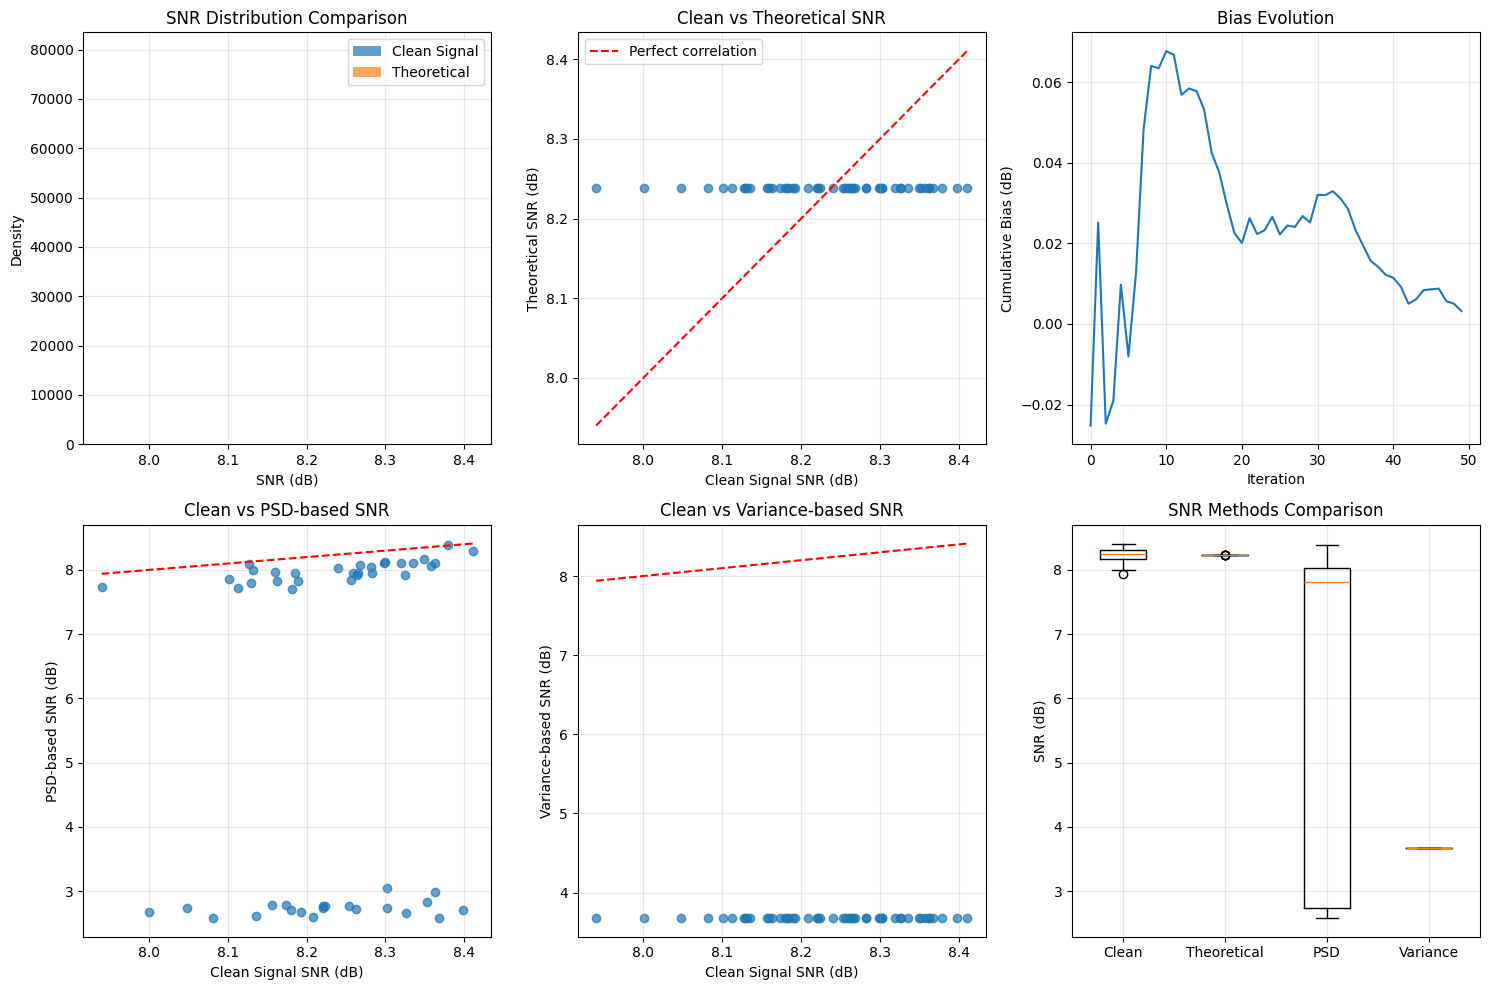

In [31]:
import torch
import torch.fft
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

class SignalGen:
    def __init__(self, fs=8192, T=1.0, amplitudes=(1, 1, 1, 1), noise_variance=0.09, seed=42):
        self.fs = fs
        self.T = T
        self.amplitudes = amplitudes
        self.noise_variance = noise_variance
        self.seed = seed

    def generate(self):
        torch.manual_seed(self.seed)
        
        frequencies = [
            torch.randint(low=3, high=9, size=(1,)).item(),
            torch.randint(low=10, high=99, size=(1,)).item(),
            torch.randint(low=100, high=999, size=(1,)).item(),
            torch.randint(low=1000, high=3400, size=(1,)).item()
        ]
        
        n_samples = int(self.fs * self.T)
        t = torch.linspace(0, self.T, n_samples, dtype=torch.float32)
        
        x_clean = sum(a * torch.sin(2 * torch.pi * f * t) for a, f in zip(self.amplitudes, frequencies))
        noise = torch.sqrt(torch.tensor(self.noise_variance)) * torch.randn(n_samples)
        x_noisy = x_clean + noise
        
        return t, x_noisy, x_clean, frequencies

class SNRAnalyzer:
    def __init__(self, fs=8192):
        self.fs = fs

    def estimate_snr_clean_signal(self, x_clean, x_noisy):
        """Method 1: Using clean signal (ground truth)"""
        noise = x_noisy - x_clean
        power_signal = torch.mean(x_clean ** 2)
        power_noise = torch.mean(noise ** 2)
        
        epsilon = 1e-10
        snr_linear = power_signal / (power_noise + epsilon)
        snr_db = 10 * torch.log10(snr_linear)
        return snr_db.item()
    
    def estimate_snr_theoretical(self, x_clean, noise_variance):
        """Method 2: Using theoretical noise variance"""
        power_signal = torch.mean(x_clean ** 2)
        snr_linear = power_signal / noise_variance
        snr_db = 10 * torch.log10(snr_linear)
        return snr_db.item()
    
    def estimate_snr_psd_based(self, x_noisy, signal_frequencies, bandwidth=10):
        """Method 3: Using PSD to estimate signal and noise power"""
        N = len(x_noisy)
        Xf = torch.fft.fft(x_noisy)
        psd = torch.abs(Xf)**2 / (self.fs * N)
        freqs = torch.fft.fftfreq(N, d=1.0/self.fs)
        
        # Get positive frequencies
        positive = freqs >= 0
        freqs_pos = freqs[positive]
        psd_pos = psd[positive]
        psd_pos = 2 * psd_pos
        psd_pos[0] /= 2
        if N % 2 == 0:
            psd_pos[-1] /= 2
        
        # Estimate signal power from peaks around known frequencies
        signal_power = 0
        for freq in signal_frequencies:
            # Find frequency bin closest to signal frequency
            freq_idx = torch.argmin(torch.abs(freqs_pos - freq))
            # Sum power in a bandwidth around the peak
            start_idx = max(0, freq_idx - bandwidth//2)
            end_idx = min(len(psd_pos), freq_idx + bandwidth//2)
            signal_power += torch.sum(psd_pos[start_idx:end_idx])
        
        # Estimate noise power from remaining spectrum
        total_power = torch.sum(psd_pos)
        noise_power = total_power - signal_power
        
        snr_linear = signal_power / noise_power
        snr_db = 10 * torch.log10(snr_linear)
        return snr_db.item()
    
    def estimate_snr_variance_based(self, x_noisy, quiet_regions=None):
        """Method 4: Estimate noise from signal variance in quiet regions"""
        if quiet_regions is None:
            # Use entire signal variance as upper bound
            total_power = torch.var(x_noisy)
            # Rough estimate assuming 50% signal, 50% noise
            noise_power = total_power * 0.3  # Conservative estimate
            signal_power = total_power - noise_power
        else:
            # Use specified quiet regions to estimate noise
            noise_samples = torch.cat([x_noisy[start:end] for start, end in quiet_regions])
            noise_power = torch.var(noise_samples)
            signal_power = torch.var(x_noisy) - noise_power
        
        snr_linear = signal_power / noise_power
        snr_db = 10 * torch.log10(snr_linear)
        return snr_db.item()

def run_consistency_analysis():
    """Run comprehensive SNR consistency analysis"""
    fs = 4096
    T = 1.0
    ampl = (1, 1, 1, 1)
    noise_variance = 0.3
    M = 50  # Reduced for faster analysis
    
    analyzer = SNRAnalyzer(fs=fs)
    
    # Storage for different SNR estimates
    snr_clean = []
    snr_theoretical = []
    snr_psd = []
    snr_variance = []
    
    print("Running SNR consistency analysis...")
    print(f"True noise variance: {noise_variance}")
    
    for i in range(M):
        generator = SignalGen(fs=fs, T=T, amplitudes=ampl, noise_variance=noise_variance, seed=i)
        t, x_noisy, x_clean, frequencies = generator.generate()
        
        # Method 1: Clean signal (ground truth)
        snr1 = analyzer.estimate_snr_clean_signal(x_clean, x_noisy)
        snr_clean.append(snr1)
        
        # Method 2: Theoretical
        snr2 = analyzer.estimate_snr_theoretical(x_clean, noise_variance)
        snr_theoretical.append(snr2)
        
        # Method 3: PSD-based
        try:
            snr3 = analyzer.estimate_snr_psd_based(x_noisy, frequencies)
            snr_psd.append(snr3)
        except:
            snr_psd.append(np.nan)
        
        # Method 4: Variance-based
        try:
            snr4 = analyzer.estimate_snr_variance_based(x_noisy)
            snr_variance.append(snr4)
        except:
            snr_variance.append(np.nan)
    
    # Convert to numpy arrays for analysis
    snr_clean = np.array(snr_clean)
    snr_theoretical = np.array(snr_theoretical)
    snr_psd = np.array(snr_psd)
    snr_variance = np.array(snr_variance)
    
    # Remove NaN values
    snr_psd = snr_psd[~np.isnan(snr_psd)]
    snr_variance = snr_variance[~np.isnan(snr_variance)]
    
    print("\n" + "="*60)
    print("SNR CONSISTENCY ANALYSIS RESULTS")
    print("="*60)
    
    methods = {
        'Clean Signal (Ground Truth)': snr_clean,
        'Theoretical': snr_theoretical,
        'PSD-based': snr_psd,
        'Variance-based': snr_variance
    }
    
    for name, values in methods.items():
        if len(values) > 0:
            print(f"\n{name}:")
            print(f"  Mean: {np.mean(values):.2f} dB")
            print(f"  Std:  {np.std(values, ddof=1):.2f} dB")
            print(f"  Min:  {np.min(values):.2f} dB")
            print(f"  Max:  {np.max(values):.2f} dB")
        else:
            print(f"\n{name}: No valid values")
    
    # Correlation analysis
    print("\n" + "="*60)
    print("CORRELATION ANALYSIS")
    print("="*60)
    
    if len(snr_psd) > 0:
        corr_clean_psd = np.corrcoef(snr_clean[:len(snr_psd)], snr_psd)[0, 1]
        print(f"Correlation (Clean vs PSD): {corr_clean_psd:.3f}")
    
    if len(snr_variance) > 0:
        corr_clean_var = np.corrcoef(snr_clean[:len(snr_variance)], snr_variance)[0, 1]
        print(f"Correlation (Clean vs Variance): {corr_clean_var:.3f}")
    
    corr_clean_theo = np.corrcoef(snr_clean, snr_theoretical)[0, 1]
    print(f"Correlation (Clean vs Theoretical): {corr_clean_theo:.3f}")
    
    # Bias analysis
    print("\n" + "="*60)
    print("BIAS ANALYSIS (vs Ground Truth)")
    print("="*60)
    
    bias_theoretical = np.mean(snr_theoretical - snr_clean)
    print(f"Theoretical bias: {bias_theoretical:.3f} dB")
    
    if len(snr_psd) > 0:
        bias_psd = np.mean(snr_psd - snr_clean[:len(snr_psd)])
        print(f"PSD-based bias: {bias_psd:.3f} dB")
    
    if len(snr_variance) > 0:
        bias_variance = np.mean(snr_variance - snr_clean[:len(snr_variance)])
        print(f"Variance-based bias: {bias_variance:.3f} dB")
    
    # Theoretical vs actual signal power
    print("\n" + "="*60)
    print("SIGNAL POWER ANALYSIS")
    print("="*60)
    
    # Calculate theoretical signal power
    theoretical_signal_power = sum(a**2 / 2 for a in ampl)  # RMS power of sine waves
    print(f"Theoretical signal power: {theoretical_signal_power:.3f}")
    
    # Calculate actual signal power from one example
    generator = SignalGen(fs=fs, T=T, amplitudes=ampl, noise_variance=noise_variance, seed=0)
    t, x_noisy, x_clean, frequencies = generator.generate()
    actual_signal_power = torch.mean(x_clean ** 2).item()
    print(f"Actual signal power: {actual_signal_power:.3f}")
    print(f"Power ratio: {actual_signal_power/theoretical_signal_power:.3f}")
    
    # Theoretical SNR
    theoretical_snr_db = 10 * np.log10(theoretical_signal_power / noise_variance)
    print(f"Theoretical SNR: {theoretical_snr_db:.2f} dB")
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: SNR distributions
    plt.subplot(2, 3, 1)
    plt.hist(snr_clean, bins=15, alpha=0.7, label='Clean Signal', density=True)
    plt.hist(snr_theoretical, bins=15, alpha=0.7, label='Theoretical', density=True)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Density')
    plt.title('SNR Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Scatter plot - Clean vs Theoretical
    plt.subplot(2, 3, 2)
    plt.scatter(snr_clean, snr_theoretical, alpha=0.7)
    plt.plot([min(snr_clean), max(snr_clean)], [min(snr_clean), max(snr_clean)], 'r--', label='Perfect correlation')
    plt.xlabel('Clean Signal SNR (dB)')
    plt.ylabel('Theoretical SNR (dB)')
    plt.title('Clean vs Theoretical SNR')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Bias over iterations
    plt.subplot(2, 3, 3)
    bias_evolution = np.cumsum(snr_theoretical - snr_clean) / np.arange(1, len(snr_clean) + 1)
    plt.plot(bias_evolution)
    plt.xlabel('Iteration')
    plt.ylabel('Cumulative Bias (dB)')
    plt.title('Bias Evolution')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: PSD comparison if available
    if len(snr_psd) > 0:
        plt.subplot(2, 3, 4)
        plt.scatter(snr_clean[:len(snr_psd)], snr_psd, alpha=0.7)
        plt.plot([min(snr_clean[:len(snr_psd)]), max(snr_clean[:len(snr_psd)])], 
                [min(snr_clean[:len(snr_psd)]), max(snr_clean[:len(snr_psd)])], 'r--')
        plt.xlabel('Clean Signal SNR (dB)')
        plt.ylabel('PSD-based SNR (dB)')
        plt.title('Clean vs PSD-based SNR')
        plt.grid(True, alpha=0.3)
    
    # Plot 5: Variance comparison if available
    if len(snr_variance) > 0:
        plt.subplot(2, 3, 5)
        plt.scatter(snr_clean[:len(snr_variance)], snr_variance, alpha=0.7)
        plt.plot([min(snr_clean[:len(snr_variance)]), max(snr_clean[:len(snr_variance)])], 
                [min(snr_clean[:len(snr_variance)]), max(snr_clean[:len(snr_variance)])], 'r--')
        plt.xlabel('Clean Signal SNR (dB)')
        plt.ylabel('Variance-based SNR (dB)')
        plt.title('Clean vs Variance-based SNR')
        plt.grid(True, alpha=0.3)
    
    # Plot 6: All methods comparison
    plt.subplot(2, 3, 6)
    methods_plot = [snr_clean, snr_theoretical]
    labels_plot = ['Clean', 'Theoretical']
    
    if len(snr_psd) > 0:
        methods_plot.append(snr_psd)
        labels_plot.append('PSD')
    
    if len(snr_variance) > 0:
        methods_plot.append(snr_variance)
        labels_plot.append('Variance')
    
    plt.boxplot(methods_plot, tick_labels=labels_plot)
    plt.ylabel('SNR (dB)')
    plt.title('SNR Methods Comparison')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_consistency_analysis()